Modeling: Mass Total + Source Inversion
=======================================

This script fits `Interferometer` dataset of a 'galaxy-scale' strong lens with a model where:

 - The lens galaxy's light is omitted (and is not present in the simulated data).
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's light is a parametric `VoronoiMagnification` `Pixelization` and `Constant`
   regularization.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
from utils import fitutil as af
import utils as al
import utils.plot as aplt
import numpy as np

/workspace
Working Directory has been set to `/workspace`


2021-10-14 17:32:23,199 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/fitutil/config
2021-10-14 17:32:23,248 - confutil.conf - WARNING - No configuration found at path /workspace/config


2021-10-14 17:32:23,300 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/galaxyutil/config
2021-10-14 17:32:23,362 - confutil.conf - WARNING - No configuration found at path /workspace/config
2021-10-14 17:32:23,383 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/config
2021-10-14 17:32:23,448 - confutil.conf - WARNING - No configuration found at path /workspace/config


__Masking__

We define the ‘real_space_mask’ which defines the grid the image the strong lens is evaluated using.

In [2]:
real_space_mask = al.Mask2D.circular(
    shape_native=(800, 800), pixel_scales=0.05, radius=3.0, sub_size=1
)

__Dataset__

Load and plot the strong lens `Interferometer` dataset `mass_sie__source_sersic` from .fits files , which we will fit 
with the lens model.

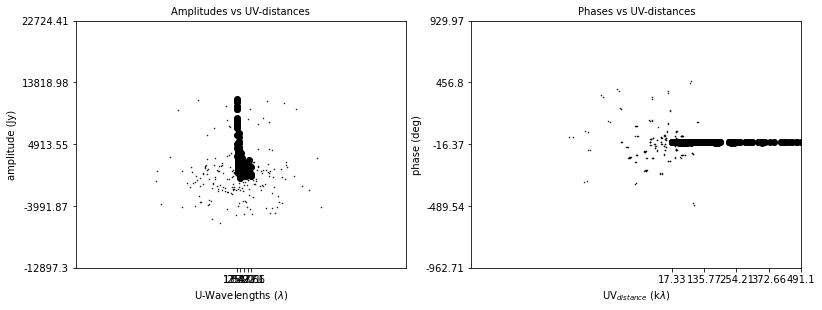

/usr/local/lib/python3.9/site-packages/pynufft/linalg/nufft_cpu.py:381: ComplexWarning: Casting complex values to real discards the imaginary part
  xx.ravel()[self.NdCPUorder * self.batch + bat] = k.ravel()[


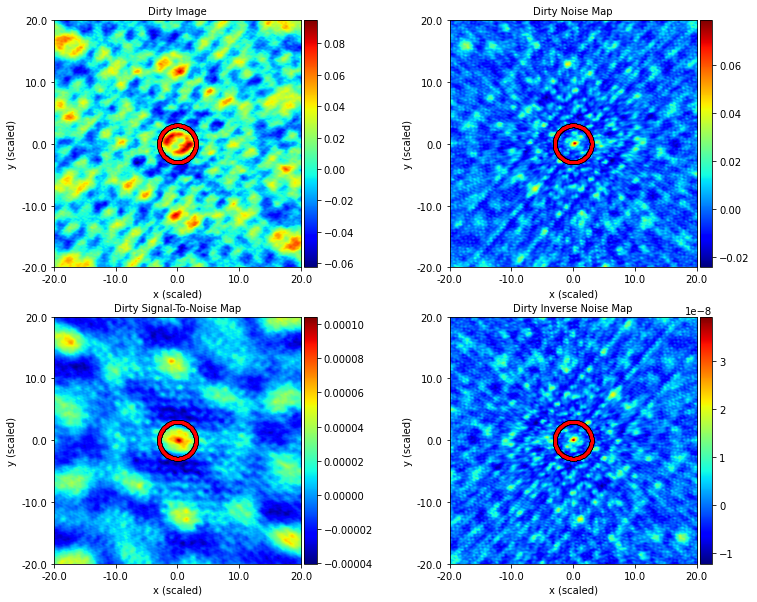

In [3]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    real_space_mask=real_space_mask,
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

We now create the `Interferometer` object which is used to fit the lens model.

This includes a `SettingsInterferometer`, which includes the method used to Fourier transform the real-space 
image of the strong lens to the uv-plane and compare directly to the visiblities. We use a non-uniform fast Fourier 
transform, which is the most efficient method for interferometer datasets containing ~1-10 million visibilities.

In [4]:
settings_interferometer = al.SettingsInterferometer(
    transformer_class=al.TransformerNUFFT
)
interferometer = interferometer.apply_settings(settings=settings_interferometer)

__Model__

We compose our lens model using `Model` objects, which represent the galaxies we fit to our data. In this 
example our lens model is:

 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters].
 - An `EllSersic` `LightProfile` for the source galaxy's light [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=12.

NOTE: 

we assume that the lens galaxy centre is near the coordinates (0.0", 0.0"). 

If for your dataset the  lens is not centred at (0.0", 0.0"), we recommend that you either: 

 - Reduce your data so that the is centre. 
 - Manually override the lens model priors.

In [5]:
lens = af.Model(
    al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal, shear=al.mp.ExternalShear
)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search__

The lens model is fitted to the data using a non-linear search. In this example, we use the nested sampling algorithm 
Dynesty (https://dynesty.readthedocs.io/en/latest/).

The `name` and `path_prefix` below specify the path where results ae stored in the output folder:  

 `output/imaging/mass_sie__source_sersic/mass[sie]_source[bulge]/unique_identifier`.
 
__Unique Identifier__

In the path above, the `unique_identifier` appears as a collection of characters, where this identifier is generated 
based on the model, search and dataset that are used in the fit.
 
An identical combination of model, search and dataset generates the same identifier, meaning that rerunning the
script will use the existing results to resume the model-fit. In contrast, if you change the model, search or dataset,
a new unique identifier will be generated, ensuring that the model-fit results are output into a separate folder. 

__Number Of Cores__

We include an input `number_of_cores`, which when above 1 means that Dynesty uses parallel processing to sample multiple 
lens models at once on your CPU. When `number_of_cores=2` the search will run roughly two times as
fast, for `number_of_cores=3` three times as fast, and so on. The downside is more cores on your CPU will be in-use
which may hurt the general performance of your computer.

You should experiment to figure out the highest value which does not give a noticeable loss in performance of your 
computer. If you know that your processor is a quad-core process you should be able to use `number_of_cores=4`. For 
users on a Windows Operating system, using `number_of_cores>1` may lead to an error, in which case it should be 
reduced back to 1 to fix it.

In [6]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer"),
    name="mass[sie]_source[inversion]",
    unique_tag=dataset_name,
    nlive=50,
    number_of_cores=1,
)

2021-10-14 17:32:27,326 - fitutil.non_linear.abstract_search - INFO - Creating search


__Analysis__

The `AnalysisInterferometer` object defines the `log_likelihood_function` used by the non-linear search to fit the 
model to the `Interferometer`dataset.

For interferometer model-fits, we include a `SettingsInversion` object which describes how the linear algebra 
calculations required to use an `Inversion` are performed. One of two different approaches can be used: 

 - **Matrices:** Use a numerically more accurate matrix formalism to perform the linear algebra. For datasets 
 of < 100 0000 visibilities this approach is computationally feasible, and if your dataset is this small we we recommend 
 that you use this option (by setting `use_linear_operators=False`. However, larger visibility datasets these matrices 
 require excessive amounts of memory (> 16 GB) to store, making this approach unfeasible. 

 - **Linear Operators (default)**: These are slightly less accurate, but do not require excessive amounts of memory to 
 store the linear algebra calculations. For any dataset with > 1 million visibilities this is the only viable approach 
 to perform lens modeling efficiently.

In [7]:
settings_inversion = al.SettingsInversion(use_linear_operators=True)

analysis = al.AnalysisInterferometer(
    dataset=interferometer, settings_inversion=settings_inversion
)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

Checkout the output folder for live outputs of the results of the fit, including on-the-fly visualization of the best 
fit model!

In [ ]:
result = search.fit(model=model, analysis=analysis)


__Result__

The search returns a result object, which includes: 

 - The lens model corresponding to the maximum log likelihood solution in parameter space.
 - The corresponding maximum log likelihood `Tracer` and `FitInterferometer` objects.
 - Information on the posterior as estimated by the `Dynesty` non-linear search.

In [ ]:
print(result.max_log_likelihood_instance)

tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=real_space_mask.masked_grid_sub_1
)
tracer_plotter.subplot_tracer()

fit_interferometer_plotter = aplt.FitInterferometerPlotter(
    fit=result.max_log_likelihood_fit
)
fit_interferometer_plotter.subplot_fit_interferometer()
fit_interferometer_plotter.subplot_fit_dirty_images()

dynesty_plotter = aplt.DynestyPlotter(samples=result.samples)
dynesty_plotter.cornerplot()